In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from HexDetector import hex_radius_inner_to_outer
from analysis_functions import *

set_matplotlib_style()

In [2]:
run_number = 320
pool_number = 6
# run_path = f'/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run{run_number}-Pool{pool_number}_treeParam.root'
# run_path = f'/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run{run_number}-Pool{pool_number}_treeParam.root'
base_path = '/local/home/dn277127/Bureau/picosec/'
run_path = f'{base_path}Run{run_number}-Pool{pool_number}_treeParam.root'
merged_run_path = f'{base_path}run{run_number}_merged.root'
# run_path = f'/home/dylan/Desktop/picosec/Run{run_number}-Pool{pool_number}_treeParam.root'


In [3]:
tree = get_tree(run_path, 'ParameterTree')
merged_tree = get_tree(merged_run_path, 'Pico')

In [4]:
# event_start, event_end = 4416, None
min_ampl, max_ampl = -1, 1  # V
min_charge, max_charge = -0, 1.0 # fC
min_charge_tot, max_charge_tot = -0, 100.0  # fC
min_echarge, max_echarge = -0, 10.0  # fC
xy_range_min, xy_range_max = -100, 100  # mm
mm_saturation_voltage_buffer = 0.01 # V Place cut this much lower than max max amplitude point
# chi2_quality = 3
chi2_quality = 1
# sat_range = None
# sat_range = [-1e9, 1e9]
sat_range = [-2.0, 2.0]

# double_peak_t_regions = None
# double_peak_t_regions = [[5.0, 5.2], [5.25, 5.35]]
double_peak_t_regions = [[-1.05, -0.96], [-0.94, -0.83]]

time_walk_nbins = 50  # For SAT vs charge
n_charge_bins = 50  # For resolution vs charge fits

mcp_min_avg_charge_per_2d_bin = 0.01
mm_min_avg_charge_per_2d_bin = 5
mcp_min_tracks_per_2d_bin = 20
mm_min_tracks_per_2d_bin = 20

time_walk_func = time_walk_double_exponential
p0_time_walk = [1.0, -0.1, 0.5, -0.1, 4] #ampl1, decay1, amp2, decay2, bsl

p0_resol = [30, -0.1, 10, -0.05, 20]
resol_func = time_walk_double_exponential
resolution_correction_to_use = 'Corrected Gaus'  # Correction to use moving forward

In [5]:
mcp_channel = 'C1'
mm_channel = 'C2'
channels = [mcp_channel, mm_channel]
global_vars = ['eventNo', 'SRSNo']
channel_vars = ['npeaks']
peak_param_channel_vars = ['ampl', 'dampl', 'charge', 'echarge', 'echargefit', 'echargefixed', 'totcharge', 'totchargefixed', 'risetime', 'tfit20','tfit20_nb', 'tnaive20', 'sigmoidR[4]']

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)


# if event_start is not None:
#     df = df[df['eventNo'] >= event_start]
# if event_end is not None:
#     df = df[df['eventNo'] <= event_end]

<Report start=0 stop=96000 source='/local/home/dn277127/Bureau/picosec/Run320-Pool6_treeParam.root:/ParameterTree;1'>


In [6]:
scint_nums = [3]
scint_vars = ['qe', 'qall', 'gpeak', 'tnaive']
scint_branches = ['srs']
scint_branches.extend([f's{num}_{var}' for num in scint_nums for var in scint_vars])
df_scint = get_df_branches(merged_tree, scint_branches)

<Report start=0 stop=67174 source='/local/home/dn277127/Bureau/picosec/run320_merged.root:/Pico;1'>


In [7]:
scint3_single_e_cuts = [0.5, 20]
scint3_good_srs = df_scint[(df_scint['s3_qall'] > scint3_single_e_cuts[0]) & (df_scint['s3_qall'] < scint3_single_e_cuts[1])]['srs'].to_numpy()
print(scint3_good_srs)
df_good_srs = df[df['SRSNo'].isin(scint3_good_srs)]
print(len(df))
print(len(df_good_srs))
df = df_good_srs

[     2      4      6 ... 112237 112238 112239]
96000
42837


In [8]:
for channel in channels:
    get_single_peak(df, channel)

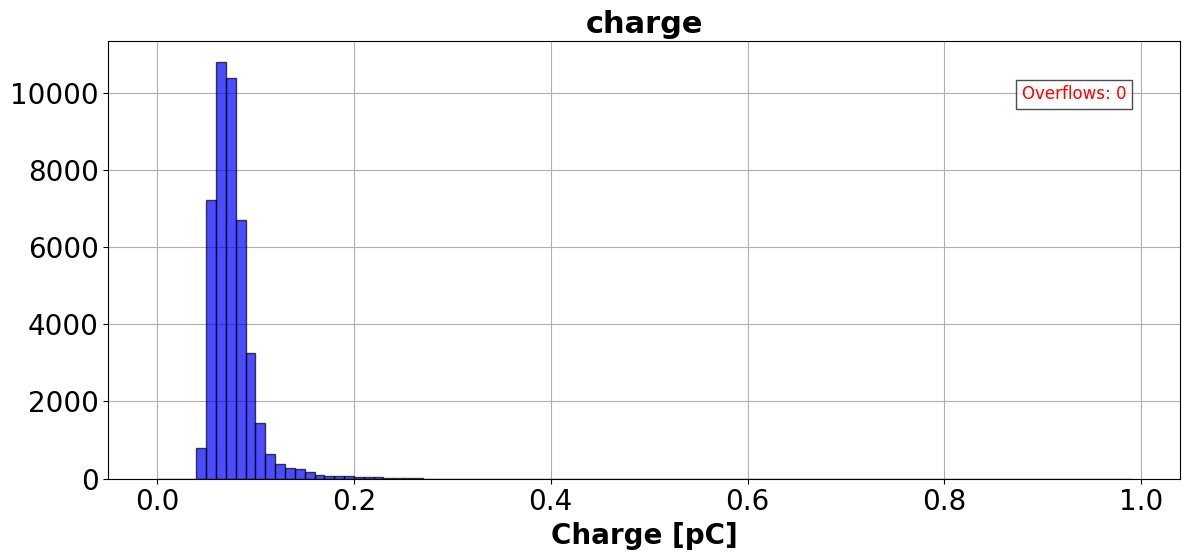

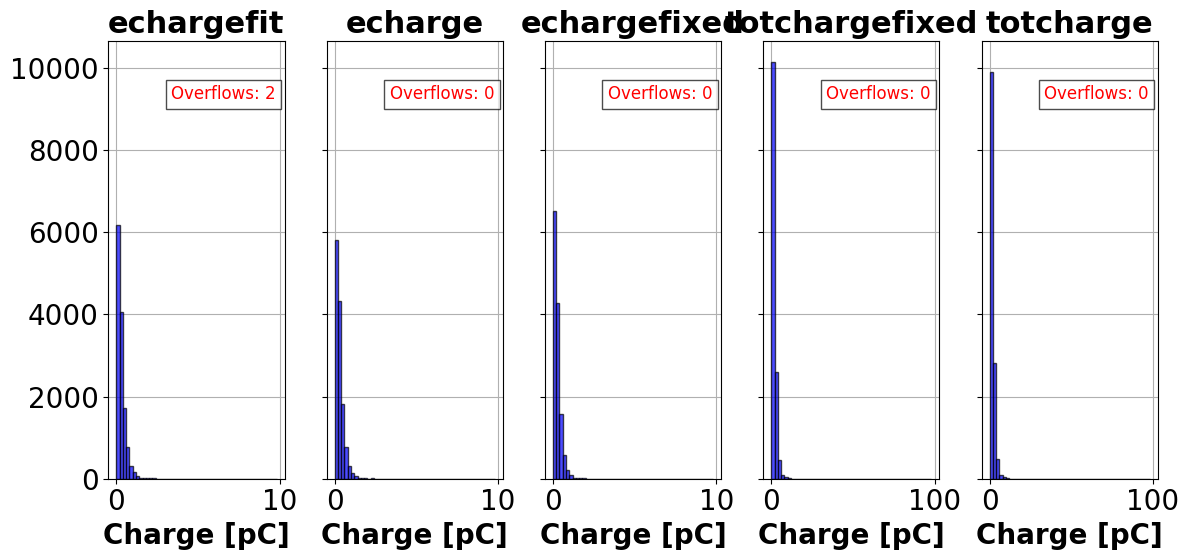

In [9]:
# Loop over channels
mcp_bins = np.arange(0, 1.0, 0.01)
ebins = np.arange(0, 10, 0.2)
totbins = np.arange(0, 100, 2)

for channel in [mcp_channel, mm_channel]:
    if channel == mcp_channel:
        charge_types = ["charge"]
    else:
        charge_types = ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"]

    num_charges = len(charge_types)

    fig, axes = plt.subplots(1, num_charges, figsize=(12,6), sharey=True)

    # Ensure axes is always iterable (wrap in list if only one subplot)
    if num_charges == 1:
        axes = [axes]

    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    for i, charge_type in enumerate(charge_types):
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins
        elif "echarge" in charge_type:
            filtered_data = charge_data[(charge_data > min_echarge) & (charge_data < max_echarge)]
            binning = ebins
        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            if channel == mcp_channel:
                binning = mcp_bins

        n_overflows = np.sum(charge_data > binning[-1])
        axes[i].hist(filtered_data, bins=binning, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        axes[i].set_title(charge_type)
        axes[i].set_xlabel('Charge [pC]')
        axes[i].grid(True, zorder=0)
        # Add overflow text
        axes[i].text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=axes[i].transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Add a background box
        )
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.savefig(f'charge_histograms_{channel}.pdf', dpi=300)
plt.savefig(f'charge_histograms_{channel}.png', dpi=300)

No handles with labels found to put in legend.


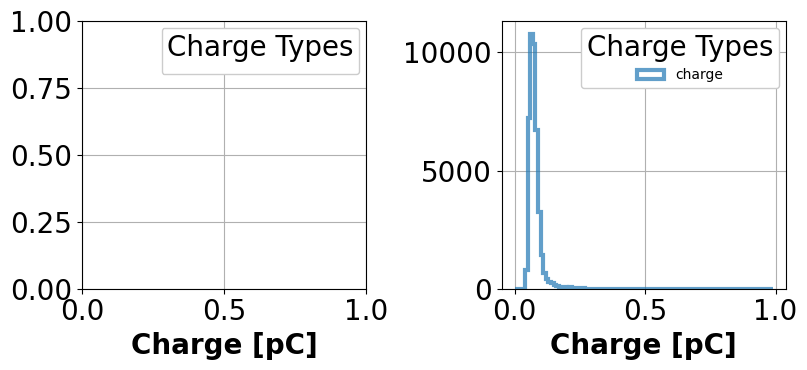

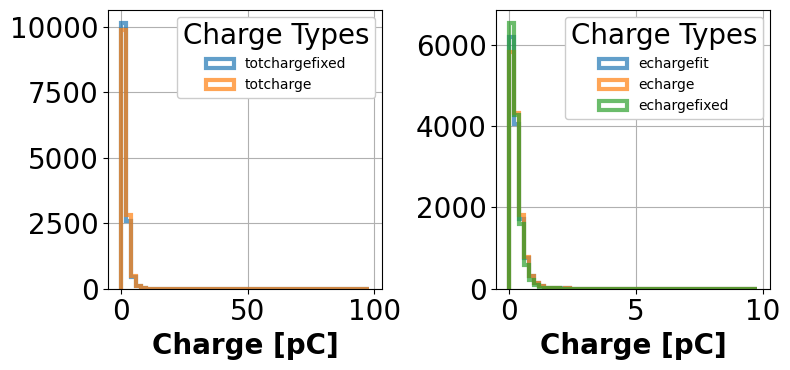

In [10]:
channel_charge_types = {
    mcp_channel: ["charge"],
    mm_channel: ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"],
}

# Loop through the channels you want to plot
for channel in channels:
    charge_types = channel_charge_types[channel]  # Select charge types based on the channel

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))  # Create figure with 2 subplots (ncols=2)

    # Loop over each charge type for the current channel
    for charge_type in charge_types:
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        # Apply filters based on the charge type (e.g., total charge vs. echarge)
        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins
            ax_num = 0  # First subplot (totcharge)
        elif "echarge" in charge_type:
            filtered_data = charge_data[(charge_data > min_echarge) & (charge_data < max_echarge)]
            binning = ebins
            ax_num = 1
        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            ax_num = 1  # Second subplot (echarge)
            if channel == mcp_channel:
                binning = mcp_bins  # Special binning for mcp

        # Plot the histogram
        n, bins, _ = axs[ax_num].hist(filtered_data, bins=binning, alpha=0.7, label=charge_type,
                                      zorder=2, histtype='step', linewidth=3)

        # Optional: Adding labels on top of histogram lines (bins)
        for i in range(len(bins)-1):
            # Find the position to put the label (at the middle of each bin)
            bin_center = (bins[i] + bins[i+1]) / 2
            count = n[i]  # Get the count (height) of the histogram at this bin
            # axs[ax_num].text(bin_center, count, f'{int(count)}', ha='center', va='bottom', fontsize=8)

    # Customize the plots
    axs[0].set_xlabel('Charge [pC]')
    axs[0].grid(True)
    axs[1].set_xlabel('Charge [pC]')
    axs[1].grid(True)

    # Add legends to the subplots
    axs[0].legend(title="Charge Types")
    axs[1].legend(title="Charge Types")

    # Set title for the current channel
    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    # Adjust the layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show plot for the current channel
    plt.show()

In [11]:
time_col = 'tfit20_nb'
df[f'{mm_channel}_time_diff'] = df[f'peakparam_{mm_channel}/peakparam_{mm_channel}.{time_col}'] - df[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.{time_col}']

filters = {channel: {} for channel in channels}
for channel in channels:
    
    tot_charge_data = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
    filters[channel].update({'totcharge_cut': (tot_charge_data > min_charge_tot) & (tot_charge_data < max_charge_tot)})

    echarge_data = df[f'peakparam_{channel}/peakparam_{channel}.echarge']
    filters[channel].update({'echarge_cut': (echarge_data > min_echarge) & (echarge_data < max_echarge)})

    echarge_fit_data = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    filters[channel].update({'echargefit_cut': (echarge_fit_data > min_echarge) & (echarge_fit_data < max_echarge)})

    charge_data = df[f'peakparam_{channel}/peakparam_{channel}.charge']
    filters[channel].update({'charge_cut': (charge_data > min_charge_tot) & (charge_data < max_charge_tot)})

    ampl_data = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    filters[channel].update({'ampl_cut': (ampl_data > min_ampl) & (ampl_data < max_ampl)})

    dampl_data = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
    filters[channel].update({'dampl_cut': (dampl_data > min_ampl) & (dampl_data < max_ampl)})
    # filters[channel].update({'saturation_cut': dampl_data < mm_saturation_voltage})
    mm_saturation_voltage = np.max(dampl_data) * (1 - mm_saturation_voltage_buffer)
    filters[channel].update({'saturation_cut': dampl_data < mm_saturation_voltage})


    #
    # echarge_fit_data = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    # filters[channel].update({'echargefit_cut': (echarge_fit_data > min_charge) & (echarge_fit_data < max_charge)})

time_diff_data = df[f'{mm_channel}_time_diff']
filters[mm_channel].update({'time_diff_na_cut': ~pd.isna(time_diff_data)})
time_diff_median = np.nanmedian(time_diff_data)
filters[mm_channel].update({'time_diff_range_cut': (time_diff_data > time_diff_median + sat_range[0]) & (time_diff_data < time_diff_median + sat_range[1])})
print(f'Time diff median={time_diff_median}, cuts=[{time_diff_median + sat_range[0]}, {time_diff_median + sat_range[1]}]')

# Get filtered dataframes for each channel -- charge filter
mcp_charge_filtered_df = df[filters[mcp_channel]['charge_cut']]
mm_charge_filtered_df = df[filters[mm_channel]['totcharge_cut']]

Time diff median=-8.528853574049748, cuts=[-10.528853574049748, -6.528853574049748]


C1 Number of outliers: 0 of 42835
C1 Number after filter: 42835 of 42835
C1 channel: min = 0.01122213416009396, max = 0.3498288776302231
C2 Number of outliers: 1 of 13312
C2 Number after filter: 13311 of 13312
C2 channel: min = 0.09423134948094185, max = 14.178914212499969


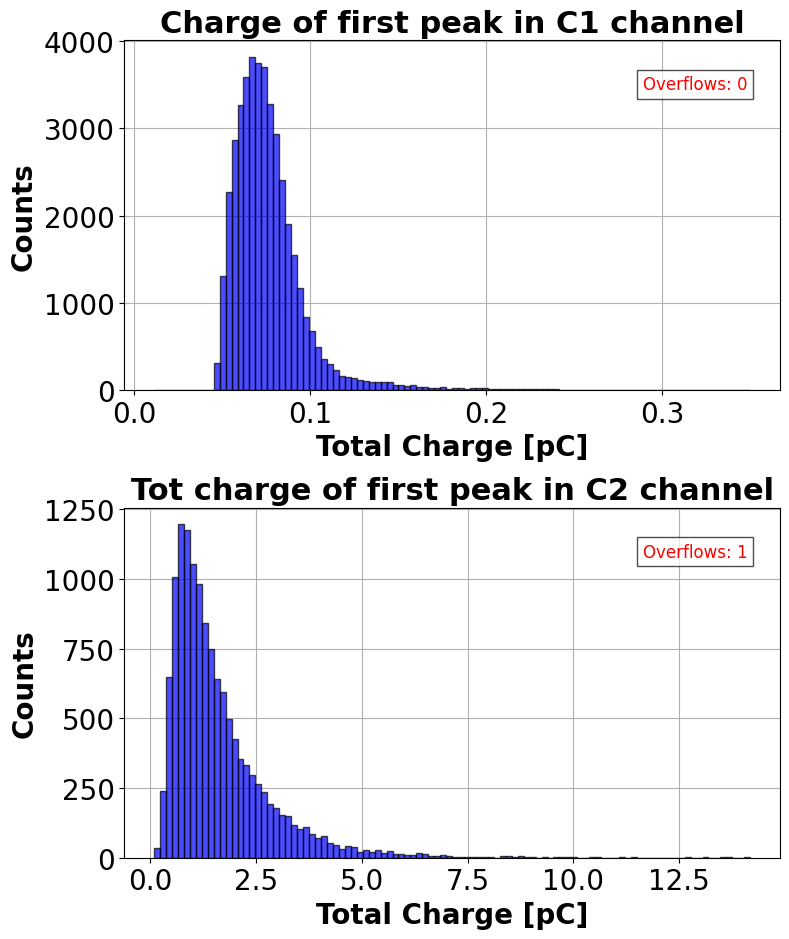

In [12]:
fig, axes = plt.subplots(nrows=len(channels), ncols=1, figsize=(8, 10))  # 3 rows, 1 column

for i, channel in enumerate(channels):
    # Get first charge or total charge based on the channel
    if channel == mcp_channel:
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df_filter = df[filters[channel]['charge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.charge']
    else:
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
        df_filter = df[filters[channel]['totcharge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.totcharge']

    # Convert to numpy arrays for filtering
    n_overflows = np.sum(first_charges_unfiltered < min_charge_tot) + np.sum(first_charges_unfiltered > max_charge_tot)  # Overflow count
    n_in_range = len(first_charges_filtered)
    n_total = n_in_range + n_overflows

    # Print outliers information
    print(f'{channel} Number of outliers: {n_overflows} of {n_total}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {n_total}')
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')

    # Plot each channel's charge histogram
    ax = axes[i]  # Use the appropriate axis in the grid
    ax.hist(first_charges_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)

    # Set title based on the channel
    if channel == mcp_channel:
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Tot charge of first peak in {channel} channel')

    # Set labels
    ax.set_xlabel('Total Charge [pC]')
    ax.set_ylabel('Counts')

    # Add overflow text
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    ax.grid(True, zorder=0)

# Adjust layout to avoid overlap and ensure titles fit
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap

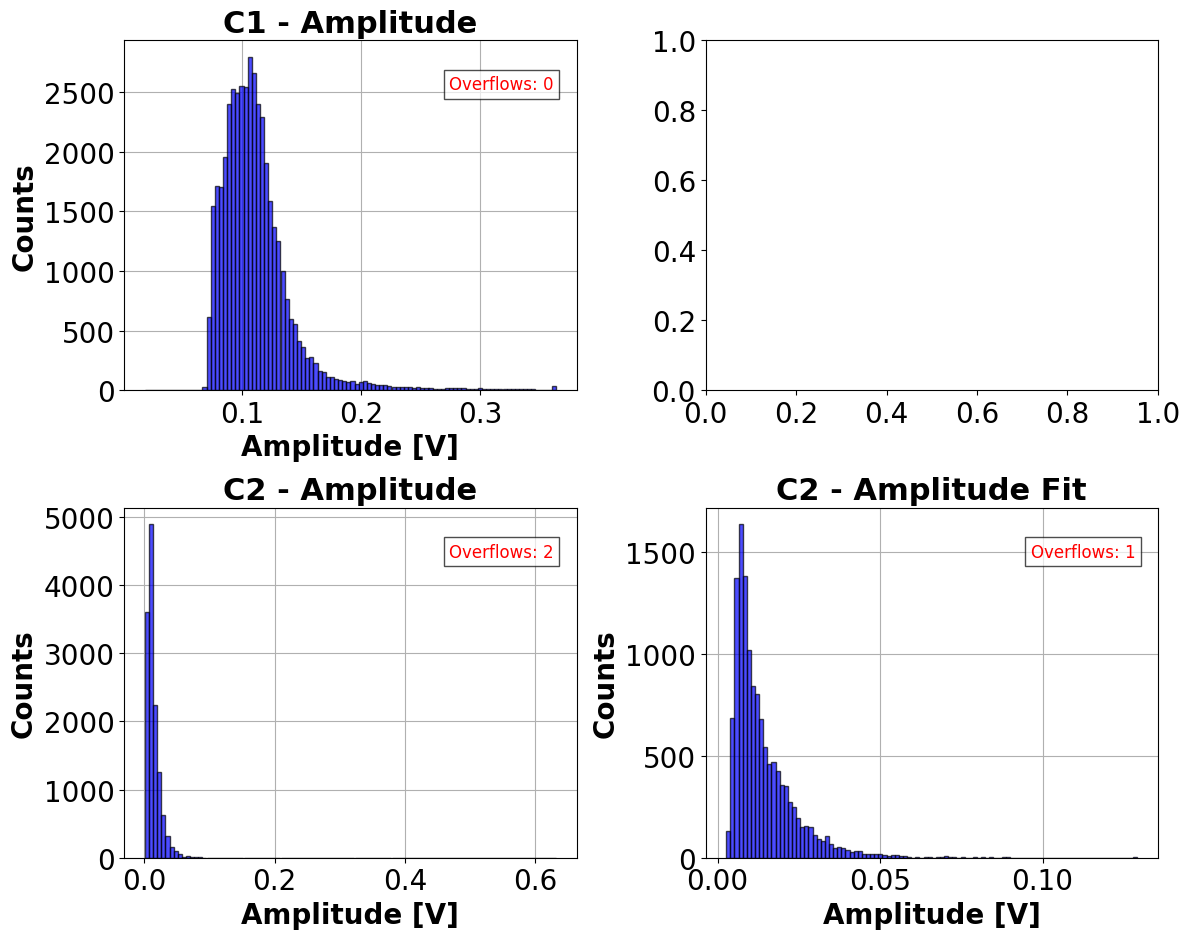

In [13]:
fig, axes = plt.subplots(nrows=len(channels), ncols=2, figsize=(12, 10))  # 3 rows, 2 columns

for i, channel in enumerate(channels):
    # First peak amplitude histogram
    first_ampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df_filter = df[filters[channel]['ampl_cut']]
    first_ampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.ampl']

    n_overflows = np.sum(first_ampls_unfiltered < min_ampl) + np.sum(first_ampls_unfiltered > max_ampl)  # Overflow count
    n_in_range = len(first_ampls_filtered)
    n_total = n_in_range + n_overflows

    # Plot first_ampls_filtered histogram
    ax = axes[i, 0]  # Left column
    ax.hist(first_ampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
    ax.set_title(f'{channel} - Amplitude')
    ax.set_xlabel('Amplitude [V]')
    ax.set_ylabel('Counts')
    ax.grid(True, zorder=0)

    # Add overflow text for first_ampls
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    # For C2, add the second amplitude (dampl) plot
    if channel == mm_channel:
        first_dampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
        df_filter = df[filters[channel]['dampl_cut']]
        first_dampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.dampl']

        n_overflows = np.sum(first_dampls_unfiltered < min_ampl) + np.sum(first_dampls_unfiltered > max_ampl)  # Overflow count
        n_in_range = len(first_dampls_filtered)
        n_total = n_in_range + n_overflows

        # Plot first_dampls_filtered histogram
        ax = axes[i, 1]  # Right column
        ax.hist(first_dampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        ax.set_title(f'{channel} - Amplitude Fit')
        ax.set_xlabel('Amplitude [V]')
        ax.set_ylabel('Counts')
        ax.grid(True, zorder=0)

        # Add overflow text for first_dampls
        ax.text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
        )

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap
plt.savefig('amplitude_histograms.pdf', dpi=300)

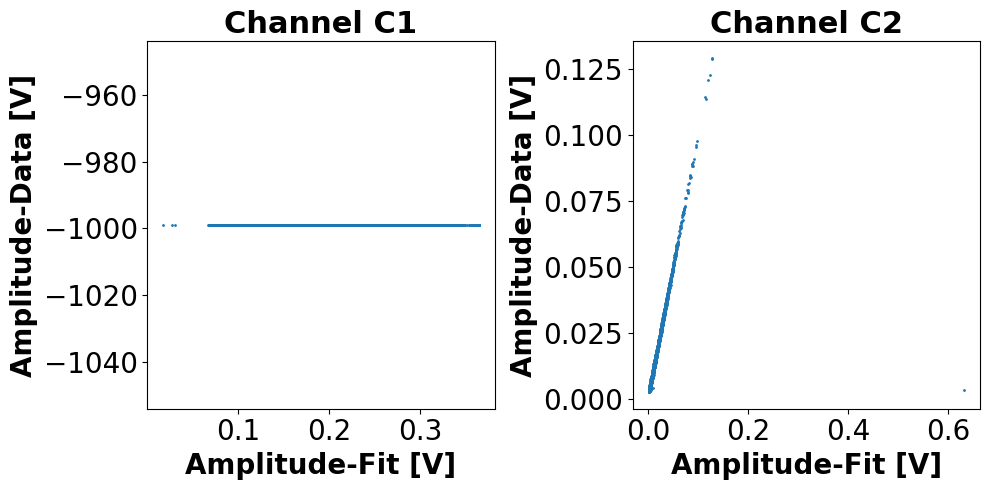

In [14]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']

    ax.scatter(ampl_filtered, dampl_filtered, s=1)
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

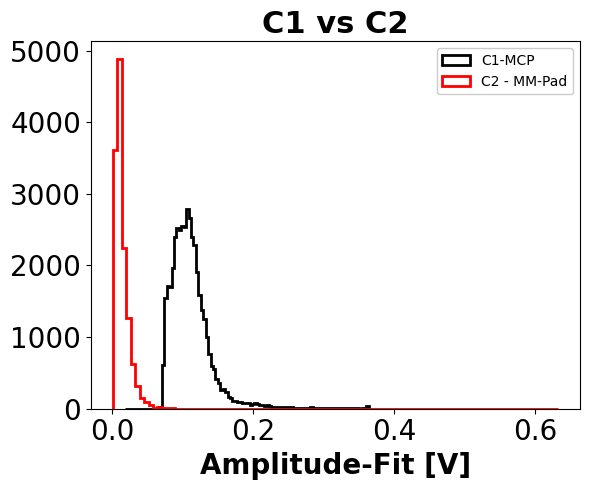

In [15]:
compare_ch_ampl = [ch for ch in filters.keys() if ch != mcp_channel]

num_plots = len(compare_ch_ampl)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(6*num_plots, 5), sharex=True, sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter MCP data once (to avoid redundant computation)
df_filter_mcp = df[filters[mcp_channel]['ampl_cut']]
mcp_ampl_filtered = df_filter_mcp[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.ampl']

for ax, ch in zip(axes, compare_ch_ampl):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['ampl_cut']]
    ch_ampl_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.ampl']

    # Plot histograms
    ax.hist(mcp_ampl_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    ax.hist(ch_ampl_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch} - MM-Pad')

    # Set title and legend
    ax.set_title(f'C1 vs {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.legend()

plt.tight_layout()

1
(2,)
[array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)]


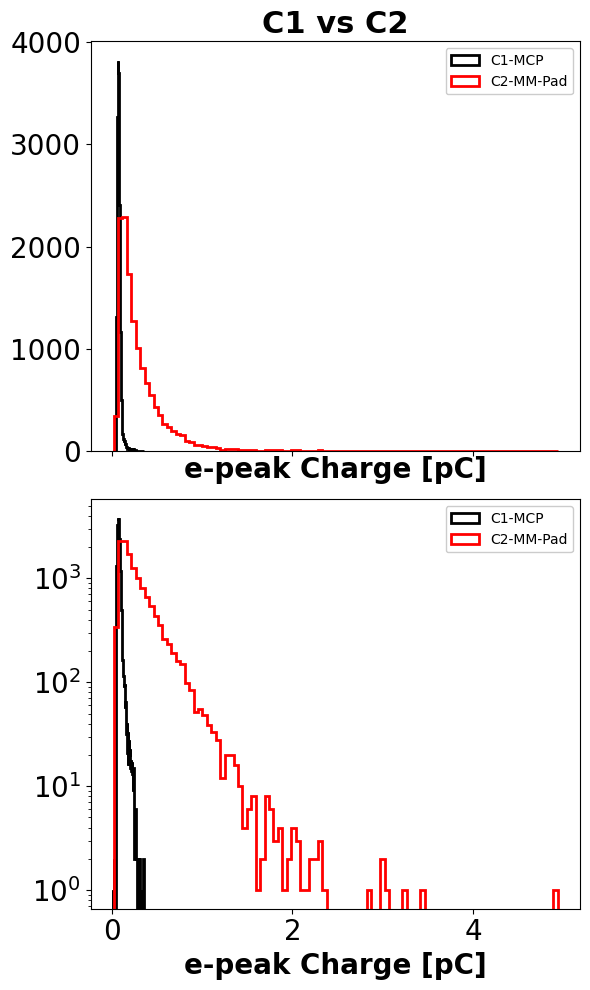

In [16]:
# Get all channels except C1
compare_ch_charge = [ch for ch in filters.keys() if ch != mcp_channel]

num_plots = len(compare_ch_charge)
print(num_plots)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)
print(axes.shape)

if num_plots == 1:
    axes = [axes]# Ensure `axes` is iterable when there's only one subplot
    print(axes)
# Filter C1 data once (to avoid redundant computation)
df_filter_mcp = df[filters[mcp_channel]['charge_cut']]
mcp_ch_filtered = df_filter_mcp[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.charge']

for col, ch in enumerate(compare_ch_charge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['echargefit_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # Linear scale histogram (first row)
    axes[col][0].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][0].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][0].set_title(f'C1 vs {ch}')
    axes[col][0].set_xlabel('e-peak Charge [pC]')
    axes[col][0].legend()

    # Log scale histogram (second row)
    axes[col][1].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][1].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][1].set_yscale('log')  # Set log scale for y-axis
    axes[col][1].set_xlabel('e-peak Charge [pC]')
    axes[col][1].legend()

plt.tight_layout()

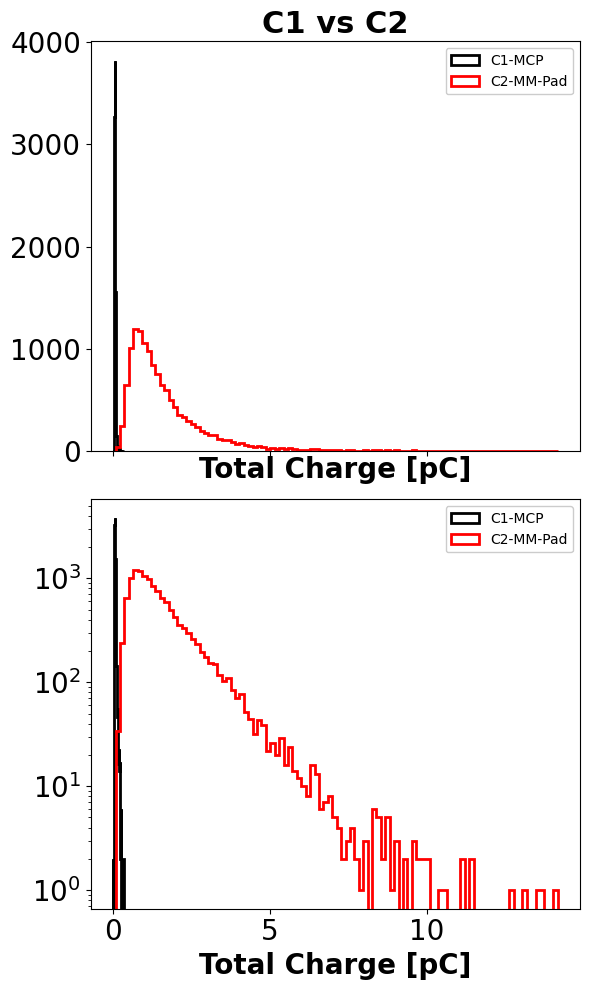

In [17]:
# Get all channels except C1
compare_ch_totcharge = [ch for ch in filters.keys() if ch != mcp_channel]

num_plots = len(compare_ch_totcharge)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_mcp = df[filters[mcp_channel]['charge_cut']]
mcp_ch_filtered = df_filter_mcp[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.charge']

for col, ch in enumerate(compare_ch_totcharge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['totcharge_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    # Linear scale histogram (first row)
    axes[col][0].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][0].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][0].set_title(f'C1 vs {ch}')
    axes[col][0].set_xlabel('Total Charge [pC]')
    axes[col][0].legend()

    # Log scale histogram (second row)
    axes[col][1].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][1].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][1].set_yscale('log')  # Set log scale for y-axis
    axes[col][1].set_xlabel('Total Charge [pC]')
    axes[col][1].legend()

plt.tight_layout()

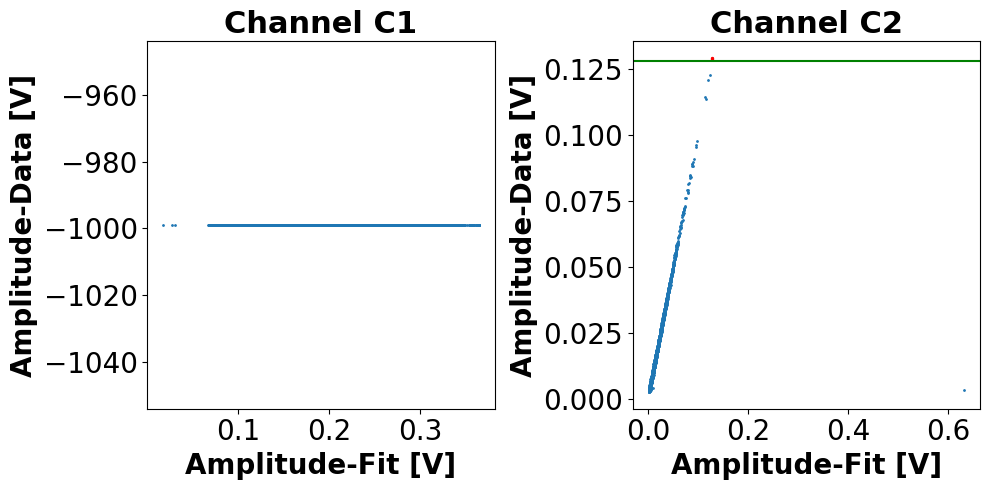

In [18]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']


    df_filter_saturation = df[filters[ch]['ampl_cut'] & ~filters[ch]['saturation_cut']]
    ampl_saturation = df_filter_saturation[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_saturation = df_filter_saturation[f'peakparam_{ch}/peakparam_{ch}.dampl']



    ax.scatter(ampl_filtered, dampl_filtered, s=1)

    if ch != mcp_channel:
        ax.scatter(ampl_saturation, dampl_saturation, s=2, color='red', label=f'Saturation {mm_channel}')
        ax.axhline(mm_saturation_voltage, color='green', linestyle='-', label='Saturation Voltage')

    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

1


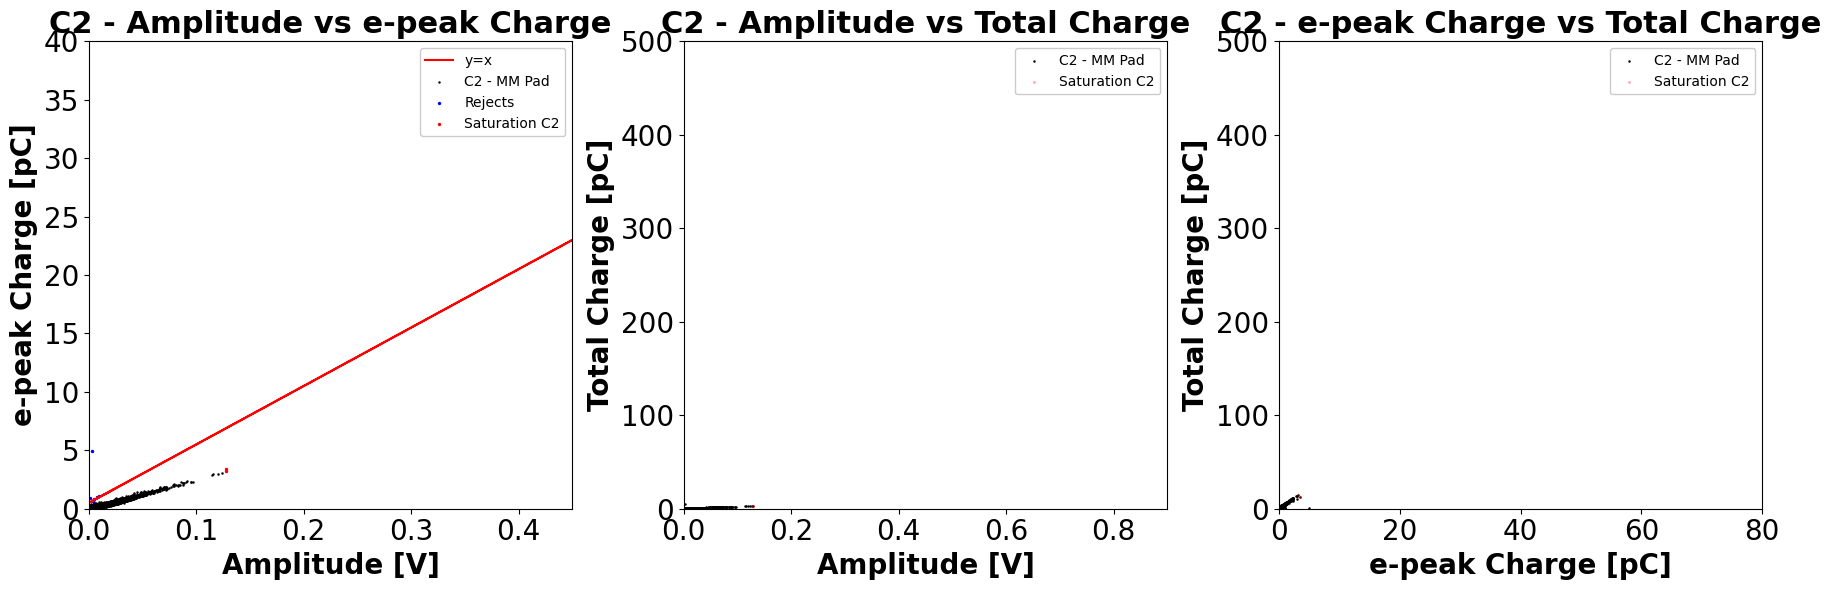

In [19]:
channels = [ch for ch in filters.keys() if ch != mcp_channel]
num_channels = len(channels)
print(num_channels)

fig, axs = plt.subplots(nrows=num_channels, ncols=3, figsize=(18, 6*num_channels), sharex=False, sharey=False)

if num_channels == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one channel

# Loop over each channel
for row, ch in enumerate(channels):
    df_filter = df[filters[ch]['ampl_cut']]

    # Extract data
    x_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    df_saturation = df[filters[ch]['ampl_cut'] & ~filters[ch]['saturation_cut']]
    x_saturation = df_saturation[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_saturation = df_saturation[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # First scatter plot (Amplitude vs e-peak Charge with rejection line)
    up_slope, up_offset = 50, 0.5
    up_rejects_filter = y_filtered > line(x_filtered, up_slope, up_offset)
    up_rejects_x = x_filtered[up_rejects_filter]
    up_rejects_y = y_filtered[up_rejects_filter]

    axs[row][0].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row][0].scatter(up_rejects_x, up_rejects_y, s=2, color='blue', label='Rejects')
    axs[row][0].scatter(x_saturation, y_saturation, s=2, color='red', label=f'Saturation {mm_channel}')
    axs[row][0].plot(np.array(x_filtered), line(np.array(x_filtered), up_slope, up_offset), color='red', label='y=x')

    axs[row][0].set_xlabel('Amplitude [V]')
    axs[row][0].set_ylabel('e-peak Charge [pC]')
    axs[row][0].set_xlim(0, 0.45)
    axs[row][0].set_ylim(0, 40)
    axs[row][0].legend()
    axs[row][0].set_title(f'{ch} - Amplitude vs e-peak Charge')

    # Second scatter plot (Amplitude vs Total Charge)
    axs[row][1].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row][1].scatter(x_saturation, y_saturation, s=2, alpha=0.2, color='red', label=f'Saturation {mm_channel}')

    axs[row][1].set_xlabel('Amplitude [V]')
    axs[row][1].set_ylabel('Total Charge [pC]')
    axs[row][1].set_xlim(0, 0.9)
    axs[row][1].set_ylim(0, 500)
    axs[row][1].legend()
    axs[row][1].set_title(f'{ch} - Amplitude vs Total Charge')

    # Third scatter plot (e-peak Charge vs Total Charge)
    x_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    x_saturation_2 = df_saturation[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_saturation_2 = df_saturation[f'peakparam_{ch}/peakparam_{ch}.totcharge']


    axs[row][2].scatter(x_filtered_2, y_filtered_2, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row][2].scatter(x_saturation_2, y_saturation_2, s=2, alpha=0.2, color='red', label=f'Saturation {mm_channel}')
    axs[row][2].set_xlabel('e-peak Charge [pC]')
    axs[row][2].set_ylabel('Total Charge [pC]')
    axs[row][2].set_xlim(0, 80)
    axs[row][2].set_ylim(0, 500)
    axs[row][2].legend()
    axs[row][2].set_title(f'{ch} - e-peak Charge vs Total Charge')

plt.tight_layout()
plt.show()

# Get the time walk parameterization raw data

n_event_bins: 133


/local/home/dn277127/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:488: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/local/home/dn277127/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:488: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:544: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


gaus fit measures = [0.023 ± 0.040, -1.1 ± 2.8, 0.050 ± 0.017, -0.17 ± 0.49, -8.567 ± 0.057]


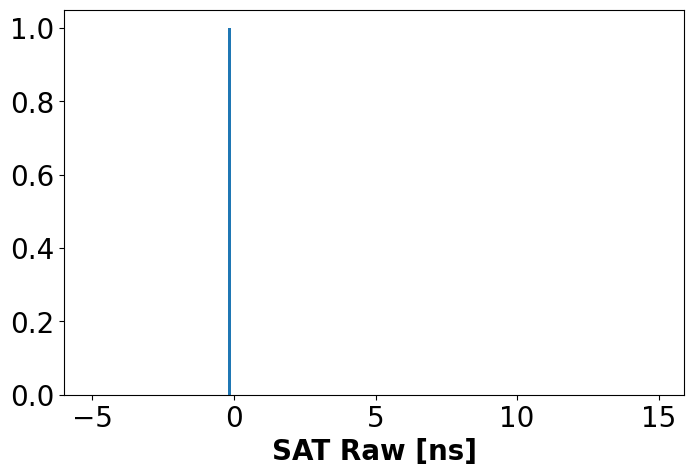

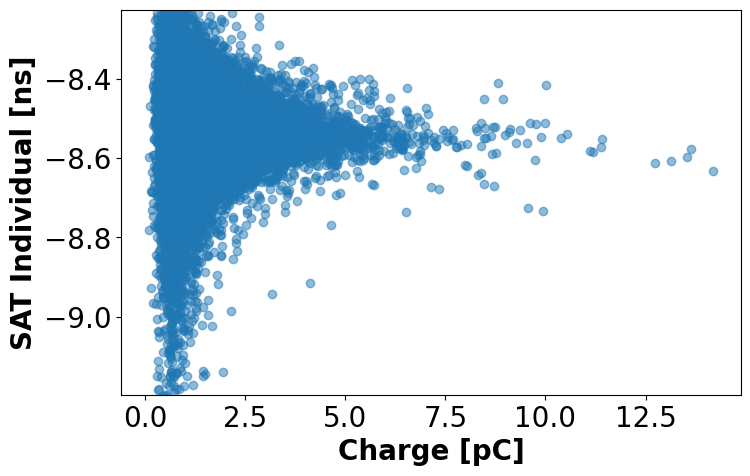

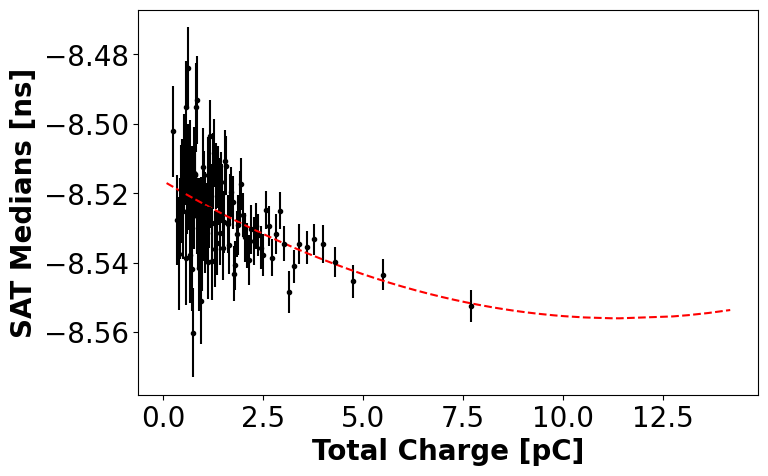

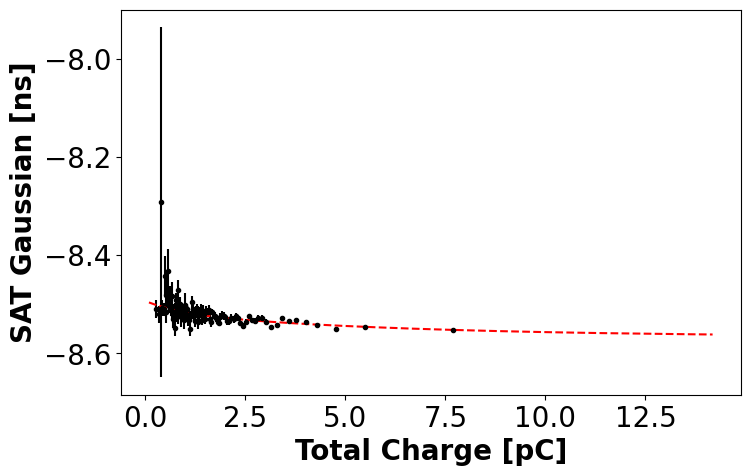

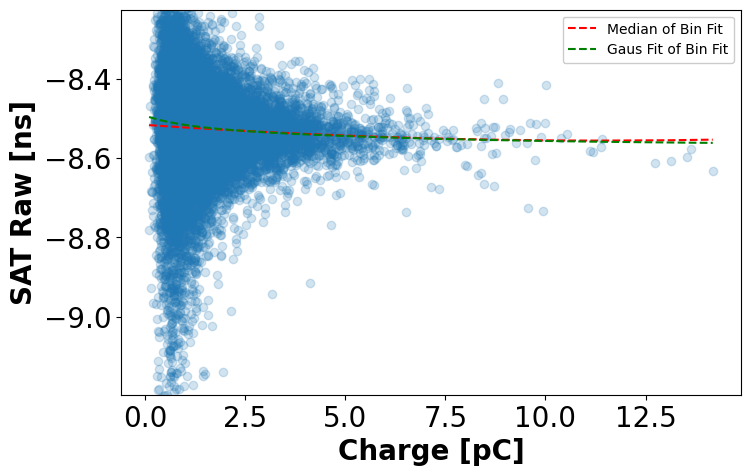

In [20]:
df_filter = df[filters[mm_channel]['totcharge_cut']]
charges = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
time_diff = df_filter[f'{mm_channel}_time_diff']

indiv_params, med_bins_params, gaus_bins_params = get_time_walk(time_diff, charges, time_walk_func, p0_time_walk, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8]),
 [<matplotlib.patches.Polygon at 0x7faedc324fd0>])

/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


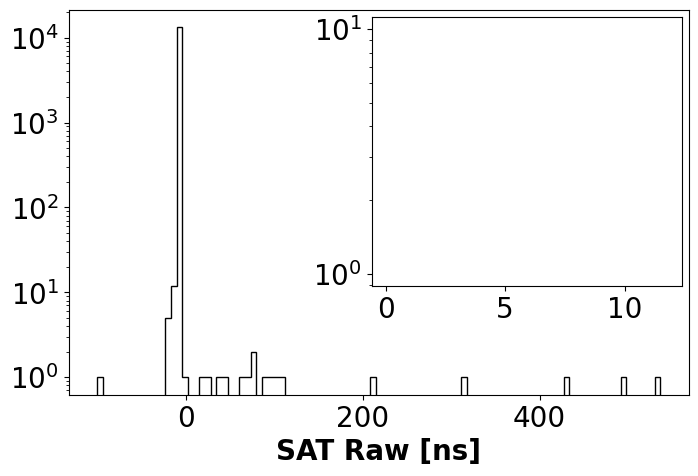

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.linspace(np.min(time_diff), np.max(time_diff), 100)
ax.hist(time_diff, bins=binning_t20_diff, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper right")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
ax_inset.set_yscale('log')
ax_inset.hist(time_diff, bins=binning_t20_diff_nom, histtype='step', color='black')

# Time walk correction using Indiv point fit, Median of Bin Fit and Gaus of Bin Fit

Individual Points Fit: [-0 ± 830, -1 ± 210, 1 ± 829, -1 ± 247, -8.31 ± 0.91]
Median of Bin Fit: [-64 ± 32613, 0.0 ± 2.4, 15 ± 19990, 0.0 ± 2.8, 40 ± 49327]
Gaus Fit of Bin Fit: [0.023 ± 0.040, -1.1 ± 2.8, 0.050 ± 0.017, -0.17 ± 0.49, -8.567 ± 0.057]


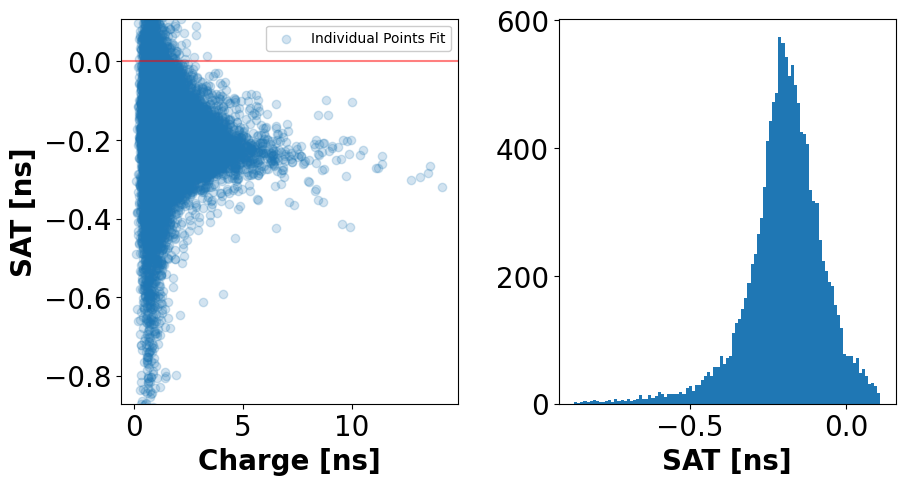

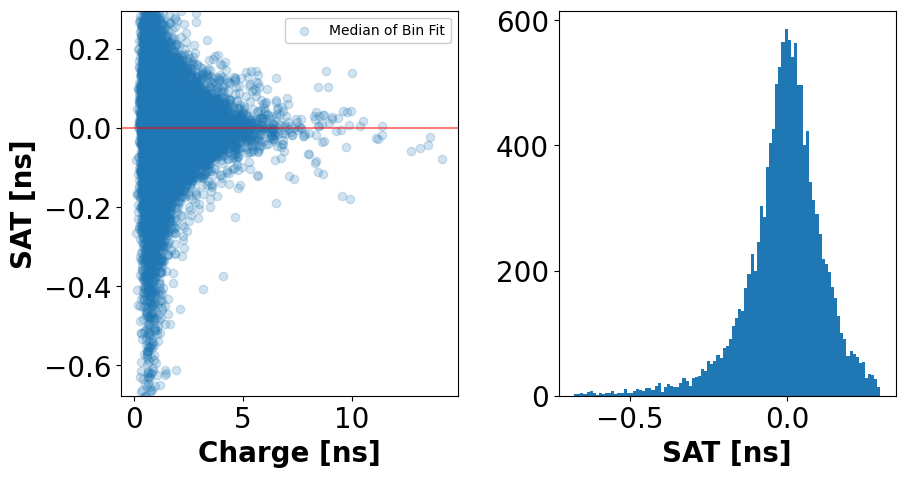

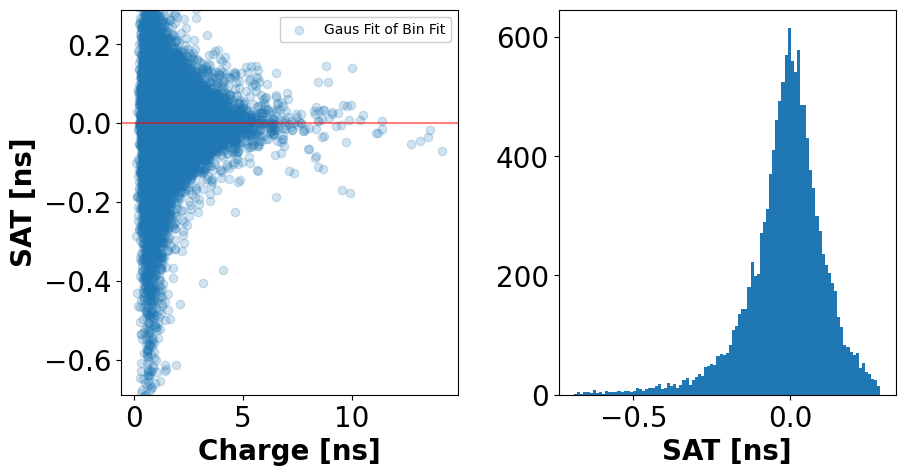

In [22]:
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_meases, cor_name in zip([indiv_params, med_bins_params, gaus_bins_params], cor_names):
    if cor_meases is None:
        print(f'{cor_name}: {cor_meases} is None, skipping')
        continue
    print(f'{cor_name}: {cor_meases}')
    cor_popt = [par.val for par in cor_meases]
    time_diff_cor = time_diff - time_walk_func(charges, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges, time_diff_cor, alpha=0.2, label=cor_name)
    axs[0].axhline(0, color='red', alpha=0.5)
    axs[0].set_xlabel('Charge [ns]')
    axs[0].set_ylabel('SAT [ns]')
    axs[1].hist(time_diff_cor, bins=np.linspace(np.nanpercentile(time_diff_cor, 1), np.nanpercentile(time_diff_cor, 99), 100))
    axs[1].set_xlabel('SAT [ns]')
    axs[0].legend()
    fig.subplots_adjust(wspace=0.3)
    # Set ylim to 2nd and 98 percentile
    axs[0].set_ylim(np.nanpercentile(time_diff_cor, 1), np.nanpercentile(time_diff_cor, 99))

In [23]:
df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['saturation_cut'] & filters[mm_channel]['time_diff_na_cut'] & filters[mm_channel]['time_diff_range_cut']]
charges = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
time_diff = df_filter[f'{mm_channel}_time_diff']

# n_charge_bins = 50
charge_bins = np.percentile(charges, np.linspace(0, 100, n_charge_bins + 1))
charge_bins = [[charge_bins[i], charge_bins[i+1]]for i in range(len(charge_bins) - 1)]

time_diff_cors = {
    'Uncorrected': time_diff,
    'Corrected Median': time_diff - time_walk_func(charges, *[par.val for par in med_bins_params]),
    'Corrected Gaus': time_diff - time_walk_func(charges, *[par.val for par in gaus_bins_params]),
}
time_diff_cor_colors = {'Uncorrected': 'k', 'Corrected Median': 'm', 'Corrected Gaus': 'c'}
charge_scan_resolutions = {}

for cor_name, time_diff_cor_i in time_diff_cors.items():
    charge_reses, charge_means, charge_events = get_charge_scan(time_diff_cor_i, charges, charge_bins, ns_to_ps=True, percentile_cuts=(5, 95), plot=False)
    charge_scan_resolutions[cor_name] = charge_reses

Text(0, 0.5, 'Time Resolution (ps)')

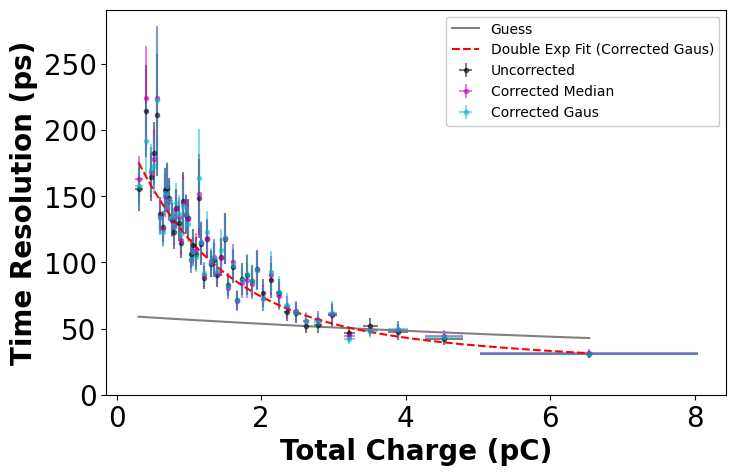

In [24]:
resol_vs_charge_popt = None

fig, ax = plt.subplots(figsize=(8, 5))

charge_bin_means, charge_bin_stds = [], []
for charge_bin in charge_bins:
    charge_bin_low, charge_bin_high = charge_bin
    mask = (charge_bin_low <= charges) & (charges < charge_bin_high)
    charge_bin_means.append(np.mean(charges[mask]))
    charge_bin_stds.append(np.std(charges[mask]))

for cor_name in time_diff_cors.keys():
    charge_res_vals = [x.val for x in charge_scan_resolutions[cor_name]]
    charge_res_errs = [x.err for x in charge_scan_resolutions[cor_name]]
    ax.errorbar(charge_bin_means, charge_res_vals, xerr=charge_bin_stds, yerr=charge_res_errs, ls='none', marker='.', color=time_diff_cor_colors[cor_name], label=cor_name, alpha=0.5)
    if cor_name == 'Corrected Gaus':
        xdata = np.array(charge_bin_means)
        ydata = np.array([x.val for x in charge_scan_resolutions['Corrected Gaus']])
        yerr = np.array([x.err for x in charge_scan_resolutions['Corrected Gaus']])

        nan_filter = np.isfinite(ydata)
        xdata, ydata, yerr = xdata[nan_filter], ydata[nan_filter], yerr[nan_filter]

        x_fit = np.linspace(min(xdata), max(xdata), 500)
        ax.plot(x_fit, resol_func(x_fit, *p0_resol), color='gray', label='Guess')

        popt, pcov = cf(resol_func, xdata, ydata, sigma=yerr, absolute_sigma=True, p0=p0_resol, maxfev=10000)

        if cor_name == resolution_correction_to_use:
            resol_vs_charge_popt = popt

        y_fit = resol_func(x_fit, *popt)

        ax.plot(x_fit, y_fit, 'r--', label='Double Exp Fit (Corrected Gaus)')
ax.set_ylim(bottom=0)
ax.legend()
ax.set_xlabel('Total Charge (pC)')
ax.set_ylabel('Time Resolution (ps)')

In [25]:
# Write relevant event data to dataframe
out_df_path = f'scan_pad_dfs/Run{run_number}-Pool{pool_number}-{mm_channel}.csv'

df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['saturation_cut'] & filters[mm_channel]['time_diff_na_cut'] & filters[mm_channel]['time_diff_range_cut']].copy()

# Get corrected time difference and add to dataframe
time_diff = df_filter[f'{mm_channel}_time_diff']
cor_popt = [par.val for par in gaus_bins_params]

time_diff_cor = time_diff - time_walk_func(charges, *cor_popt)
df_filter[f'{mm_channel}_time_diff_cor'] = time_diff_cor

# Get estimated time difference resolution and add to dataframe
df_filter[f'{mm_channel}_charge_time_res'] = resol_func(df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge'], *resol_vs_charge_popt)

save_cols = {'SRSNo': 'SRSNo',
             'eventNo': 'eventNo',
             f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge': 'totcharge',
             f'{mm_channel}_time_diff': 'time_diff',
             f'{mm_channel}_time_diff_cor': 'time_diff_cor',
             f'{mm_channel}_charge_time_res': 'charge_time_res'}
df_filter = df_filter[list(save_cols.keys())]
df_filter = df_filter.rename(columns=save_cols)
df_filter.to_csv(out_df_path, index=False)